# New York University
## Applied Data Science 2016 Final Project
----
## Measuring household income under Redatam in CensusData

**Project Description:** Lorem ipsum

**Members:**
- Felipe Gonzales
- Ilan Reinstein
- Fernando Melchor
- Nicolas Metallo

# Libraries

In [29]:
import pandas as pd
import numpy as np
import os
import sys
import simpledbf
%pylab inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


# Functions

In [30]:
def runModel(dataset, income, varForModel):
    
    '''
    This function takes a data set, runs a model according to specifications,
    and returns the model, printing the summary
    '''
    y = dataset[income].values
    X = dataset.loc[:,varForModel].values
    X = sm.add_constant(X)

    w = dataset.PONDERA
    
    lm = sm.WLS(y, X, weights=1. / w, missing = 'drop', hasconst=True).fit()
    print lm.summary()
    for i in range(1,len(varForModel)+1):
        print 'x%d: %s' % (i,varForModel[i-1])
    #testing within sample
    R_IS=[]
    R_OS=[]
    #R_prime = []
    n=500
    
    for i in range(n):  
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)
        X_train = sm.add_constant(X_train)
        X_test = sm.add_constant(X_test)
        
        lm = linear_model.LinearRegression(fit_intercept=True)
        lm.fit(X_train, y_train, sample_weight = 1. / w[:len(X_train)])
        y_hat_IS = lm.predict(X_train)
        err_IS = y_hat_IS - y_train
        R2_IS = 1 - (np.var(err_IS) / np.var(y_train))
        
        y_hat_OS = lm.predict(X_test)
        err_OS = y_hat_OS - y_test
        R2_OS = 1 - (np.var(err_OS) / np.var(y_test))
        
        R_IS.append(R2_IS)
        R_OS.append(R2_OS)
        
    print("IS R-squared for {} times is {}".format(n,np.mean(R_IS)))
    print("OS R-squared for {} times is {}".format(n,np.mean(R_OS)))


# Get Data

In [31]:
#data = pd.read_csv('/resources/data/Data Projects/ADS Project/dataFinalParaModelo.csv')
data = pd.read_csv('data/dataFinalParaModelo.csv')
data.head()

,PONDERA,HomeType,RoomsNumber,FloorMaterial,RoofMaterial,RoofCoat,Water,WaterType,Toilet,ToiletLocation,...,spouseDECCFR,headDECIFR,spouseDECIFR,headMaritalStatus,spouseMaritalStatus,headReading,spouseReading,headPlaceOfBirth,spouseplaceOfBirth,sumPredicted
0,1287,2,2,1.0,NaN,1.0,1.0,1,1,1.0,...,NaN,6.0,NaN,5.0,NaN,1.0,NaN,1.0,NaN,NaN
1,1674,2,2,1.0,1.0,1.0,1.0,1,1,1.0,...,6.0,8.0,8.0,2.0,2.0,1.0,1.0,2.0,2.0,15.469188
2,1522,2,4,1.0,NaN,1.0,1.0,1,1,1.0,...,NaN,5.0,NaN,4.0,NaN,1.0,NaN,3.0,NaN,NaN
3,1320,2,3,1.0,NaN,1.0,1.0,1,1,1.0,...,10.0,10.0,10.0,2.0,2.0,1.0,1.0,1.0,1.0,16.235857
4,1281,2,4,1.0,1.0,1.0,1.0,1,1,1.0,...,9.0,10.0,10.0,2.0,2.0,1.0,1.0,1.0,3.0,8.336136


In [32]:
data.columns

Index([u'PONDERA', u'HomeType', u'RoomsNumber', u'FloorMaterial',
       u'RoofMaterial', u'RoofCoat', u'Water', u'WaterType', u'Toilet',
       u'ToiletLocation', u'ToiletType', u'Sewer', u'DumpSites', u'Flooding',
       u'EmergencyLoc', u'UsableTotalRooms', u'SleepingRooms', u'OfficeRooms',
       u'OnlyWork', u'Kitchen', u'Sink', u'Garage', u'Ownership',
       u'CookingCombustible', u'BathroomUse', u'Working', u'HouseMembers',
       u'Memberless10', u'Membermore10', u'TotalHouseHoldIncome',
       u'TotalFamilyIncome', u'TotalFamilyIncomeDec',
       u'TotalFamilyIncomeDecReg', u'PerCapInc', u'PerCapIncDec',
       u'PerCapIncDecReg', u'CookingRec', u'WaterRec', u'OwnershipRec',
       u'Hacinamiento', u'id', u'lnHouseIncome', u'schoolAndJob', u'noJob',
       u'job', u'AGLO1', u'headAge', u'spouseAge', u'headAge2', u'spouseAge2',
       u'headFemale', u'spouseFemale', u'headEduc', u'spouseEduc',
       u'headEduc2', u'spouseEduc2', u'headPrimary', u'spousePrimary',
       u'head

# Y = "lnHouseIncome"

## Data Exploration (Correlation Matrix)

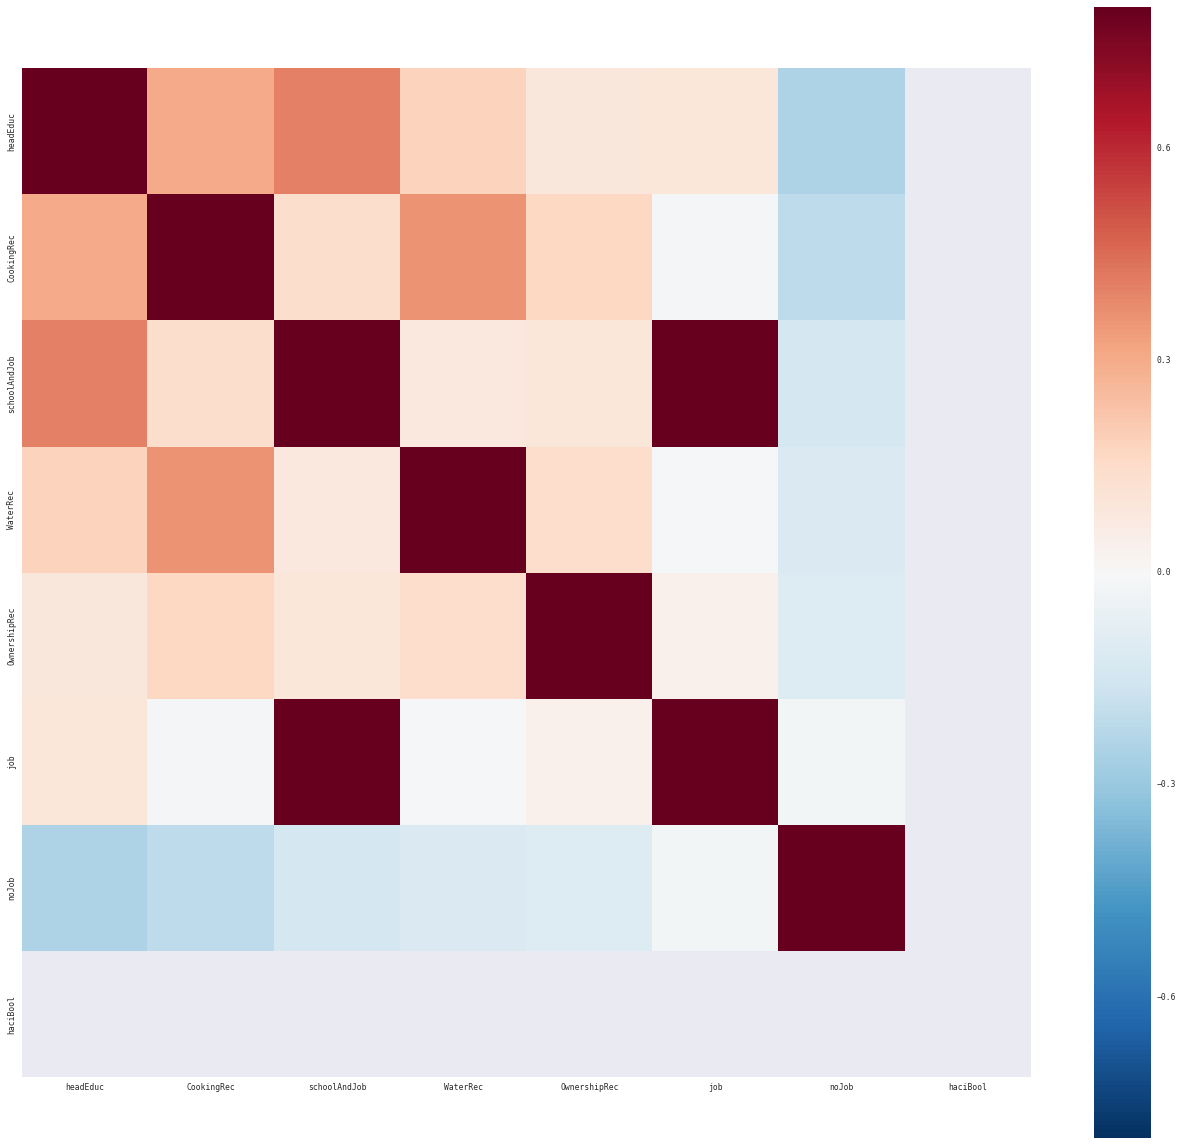

In [33]:
import seaborn as sns
sns.set(context="paper", font="monospace")

corrmat = data.loc[:,varForModel].corr()
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(corrmat, vmax=.8, square=True)
f.tight_layout()

## Data Analysis (Linear Regression, WLS)

In [34]:
df1 = data.loc[:,'HomeType':'spouseUniversity']
df2 = data.loc[:,'headJob':'spouseJob']
df3 = data.loc[:,'headMaritalStatus':'spouseplaceOfBirth']

df_lm = pd.concat([df1,df2,df3], axis=1)

## Plan A - Base para el Modelo (con R = 0.30)

In [35]:
data['hasSpouse'] = np.where(np.isnan(data.spouseJob.values),0,1)
data['spouseJob'] = np.where(np.isnan(data.spouseJob.values),0,data.spouseJob.values)

In [36]:
data['TotalFamilyIncome'].replace(to_replace=[0], value=[1] , inplace=True, axis=None)


In [37]:
data = data[data.TotalFamilyIncomeDecReg != 0]

In [38]:
data.columns

Index([u'PONDERA', u'HomeType', u'RoomsNumber', u'FloorMaterial',
       u'RoofMaterial', u'RoofCoat', u'Water', u'WaterType', u'Toilet',
       u'ToiletLocation', u'ToiletType', u'Sewer', u'DumpSites', u'Flooding',
       u'EmergencyLoc', u'UsableTotalRooms', u'SleepingRooms', u'OfficeRooms',
       u'OnlyWork', u'Kitchen', u'Sink', u'Garage', u'Ownership',
       u'CookingCombustible', u'BathroomUse', u'Working', u'HouseMembers',
       u'Memberless10', u'Membermore10', u'TotalHouseHoldIncome',
       u'TotalFamilyIncome', u'TotalFamilyIncomeDec',
       u'TotalFamilyIncomeDecReg', u'PerCapInc', u'PerCapIncDec',
       u'PerCapIncDecReg', u'CookingRec', u'WaterRec', u'OwnershipRec',
       u'Hacinamiento', u'id', u'lnHouseIncome', u'schoolAndJob', u'noJob',
       u'job', u'AGLO1', u'headAge', u'spouseAge', u'headAge2', u'spouseAge2',
       u'headFemale', u'spouseFemale', u'headEduc', u'spouseEduc',
       u'headEduc2', u'spouseEduc2', u'headPrimary', u'spousePrimary',
       u'head

In [39]:
data['income_log'] = np.log(data.TotalFamilyIncome)

In [40]:
(data['TotalFamilyIncome']==0).sum()

0

In [41]:
income1 = 'income_log'
income2 = 'TotalFamilyIncome'
income = 'TotalFamilyIncomeDecReg'

varForModel = [
    'headAge', 'headEduc','headJob', 'spouseJob', 'hasSpouse'
                      ]

runModel(data, income1, varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.293
Model:                            WLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     220.1
Date:                Wed, 07 Dec 2016   Prob (F-statistic):          6.86e-197
Time:                        14:00:35   Log-Likelihood:                -2766.5
No. Observations:                2658   AIC:                             5545.
Df Residuals:                    2652   BIC:                             5580.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.5193      0.081     80.238      0.0

In [42]:
for i in varForModel:
    print i, data[i].isnull().sum()

headAge 0
headEduc 0
headJob 0
spouseJob 0
hasSpouse 0


## Plan B - Base para el Modelo (con R = 0.42)

In [43]:
data.RoofCoat.value_counts()

1.0    2292
2.0     365
Name: RoofCoat, dtype: int64

In [44]:
data['FloorMaterial'] = np.where(np.isnan(data.FloorMaterial.values),5,data.FloorMaterial.values)
data['sumPredicted'] = np.where(np.isnan(data.sumPredicted.values),0,data.sumPredicted.values)
data['Sewer'] = np.where(np.isnan(data.Sewer.values),5,data.Sewer.values)
data['ToiletType'] = np.where(np.isnan(data.ToiletType.values),4,data.ToiletType.values)
data['Water'] = np.where(np.isnan(data.Water.values),4,data.Water.values)
data['RoofCoat'] = np.where(np.isnan(data.RoofCoat.values),2,data.RoofCoat.values)

In [45]:
data.Working.value_counts()

1    2179
2     479
Name: Working, dtype: int64

In [46]:
data.corr()['TotalFamilyIncomeDecReg'][data.corr()['TotalFamilyIncomeDecReg'] > 0.15].sort_values()

spousePrimary              0.152954
WaterRec                   0.163373
headPrimary                0.192579
HouseMembers               0.239568
CookingRec                 0.250057
hasSpouse                  0.268053
spouseLnIncomeT            0.268757
Membermore10               0.299271
RoomsNumber                0.305293
UsableTotalRooms           0.308522
headJob                    0.315838
SleepingRooms              0.318886
spouseJob                  0.338919
spousePredictedLnIncome    0.345337
spouseSecondary            0.350372
headSecondary              0.354092
headPredictedLnIncome      0.363371
headUniversity             0.364185
headLnIncomeT              0.381602
spouseLnIncome             0.388686
headEduc                   0.406296
sumPredicted               0.415837
headEduc2                  0.416498
headLnIncome               0.416832
spouseUniversity           0.427270
spouseEduc                 0.428856
spouseEduc2                0.451749
spouseP21                  0

In [47]:
income1 = 'income_log'
income2 = 'TotalFamilyIncome'
income = 'TotalFamilyIncomeDecReg'

income = 'income_log'

varForModel = [
    'SleepingRooms','HouseMembers','WaterRec',
    'CookingCombustible',
    
#     'SleepingRooms', 'UsableTotalRooms', 'RoomsNumber', 'HouseMembers', 'WaterRec', # positivas
#     'CookingCombustible', 'FloorMaterial', 'Sewer', 'ToiletType','Sink', 'RoofCoat', 'Water', #negativas
#     'headReading', 'OwnershipRec','WaterType', #sospechoso
    'headAge', 'headEduc','headJob', 'spouseJob' #base
                      ]

runModel(data, income, varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.381
Model:                            WLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     203.4
Date:                Wed, 07 Dec 2016   Prob (F-statistic):          6.70e-269
Time:                        14:00:43   Log-Likelihood:                -2591.4
No. Observations:                2658   AIC:                             5201.
Df Residuals:                    2649   BIC:                             5254.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.2900      0.119     52.847      0.0

# MODELOS FELIPE PROBANDO

In [48]:
data['TotalFamilyIncome'].replace(to_replace=[0], value=[1] , inplace=True, axis=None)


In [49]:
data['income_logPer'] = np.log(data.PerCapInc)

In [112]:
data.corr()['TotalFamilyIncome'][data.corr()['TotalFamilyIncome'] > 0.10].sort_values()

Flooding                   0.108231
spousePrimary              0.122330
OwnershipRec               0.126776
WaterRec                   0.132485
headPrimary                0.147454
HouseMembers               0.181875
hasSpouse                  0.203178
CookingRec                 0.217917
Membermore10               0.246261
headJob                    0.246625
spouseLnIncomeT            0.280361
headPredictedLnIncome      0.286899
spouseJob                  0.304031
SleepingRooms              0.307961
headSecondary              0.312949
spousePredictedLnIncome    0.314176
RoomsNumber                0.316654
spouseSecondary            0.319981
UsableTotalRooms           0.320164
headLnIncome               0.339666
headLnIncomeT              0.349351
sumPredicted               0.360143
spouseLnIncome             0.363158
headEduc                   0.378242
headUniversity             0.386140
headEduc2                  0.403212
spouseEduc                 0.417591
spouseEduc2                0

In [51]:
data['haciBool'] = (data.Hacinamiento > 3).astype(int)

# MODELO 1

In [130]:
incomePer1 = 'PerCapInc'
incomePer2 = 'income_logPer'
incomePer3 = 'PerCapIncDecReg'
income1 = 'TotalFamilyIncome'
income2 = 'income_log'
income3 = 'TotalFamilyIncomeDecReg'


varForModel = [
'headEduc',
    #'CookingRec',
    #'schoolAndJob',
    #'WaterRec',
    #'OwnershipRec',
    'job', 
    #'noJob',
    #'SleepingRooms',
    'haciBool',
    #'Hacinamiento'
]

runModel(data, income1, varForModel)
#si uso per tengo que comentar sleeping y hacibool
#runModel(data, incomePer2, varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.346
Model:                            WLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     468.2
Date:                Wed, 07 Dec 2016   Prob (F-statistic):          3.76e-244
Time:                        21:06:49   Log-Likelihood:                -25307.
No. Observations:                2658   AIC:                         5.062e+04
Df Residuals:                    2654   BIC:                         5.065e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -688.8471    181.426     -3.797      0.0

# Para CABA

In [225]:
varForModel = [
'headEduc','job', 
    'SleepingRooms',

    'schoolAndJob',
    #'Hacinamiento'
]


dataCaba = data.loc[data.AGLO1 == 32,:]
runModel(dataCaba, 'TotalFamilyIncome', varForModel)
#si uso per tengo que comentar sleeping y hacibool
#runModel(data, incomePer2, varForModel)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            WLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     59.80
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           2.14e-89
Time:                        21:33:22   Log-Likelihood:                -7536.3
No. Observations:                 785   AIC:                         1.509e+04
Df Residuals:                     774   BIC:                         1.515e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -5052.0109   2168.009     -2.330      0.0

In [173]:
dataCaba.corr()['TotalFamilyIncome'][dataCaba.corr()['TotalFamilyIncome'] >-0.2].sort_values()

headFemale                -0.170442
spouseplaceOfBirth        -0.165554
Garage                    -0.155483
headPlaceOfBirth          -0.130169
Sink                      -0.118291
Ownership                 -0.117215
OfficeRooms               -0.111855
headAge2                  -0.104317
RoofMaterial              -0.100135
BathroomUse               -0.097633
Kitchen                   -0.093201
HomeType                  -0.092322
noJob                     -0.088053
haciBool                  -0.082325
ToiletLocation            -0.081201
headAge                   -0.078962
Water                     -0.076476
CookingCombustible        -0.062990
ToiletType                -0.058658
spouseAge2                -0.048889
RoofCoat                  -0.037759
Sewer                     -0.037503
Toilet                    -0.025897
spouseFemale              -0.025176
id                        -0.015920
spouseAge                 -0.011854
PONDERA                    0.002111
Flooding                   0

In [56]:
data.AGLO1.value_counts().sum()

2658

In [57]:
data.shape

(2658, 89)

# **OLS PERFORMANCE COMPARISON**

In [ ]:
y = data[income].values
X = data.loc[:,varForModel]
X1 = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 200)

In [ ]:
Number_variables=range(len(X_train.columns[:]))

# #select best lambda for Ridge
# lambdas = np.exp(np.linspace(-5,13,200))
# lambda_r_optimal=Regularization_fit_lambda(1,X_train,y_train,lambdas,p=0.4,Graph=True)

# #select lambdas for Lasso 
# lambdas=np.exp(np.linspace(-5,6.5,200))
# lambda_l_optimal=Regularization_fit_lambda(2,X_train,y_train,lambdas,p=0.4,Graph=True)

OLS_R_2_OS_F=[]
OLS_R_2_IS_F=[]
OLS_R_2_Ridge_OS_F=[]
OLS_R_2_Ridge_IS_F=[]
OLS_R_2_Lasso_OS_F=[]
OLS_R_2_Lasso_IS_F=[]

Ridge=linear_model.Ridge(fit_intercept=True,alpha=1)
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1)

for j in Number_variables:
    # OLS
    lm = sm.OLS(formula = 'Y ~ '+ '+'.join(X_train.columns[:j+1]), 
                 data = pd.concat([X_train.iloc[:,:j+1],y_train], axis=1)).fit()
    error = lm.predict(X_test.iloc[:,:j+1]) - y_test
    R_2_OS_OLS=1-error.var()/y_test.var()
    R_2_IS_OLS = lm.rsquared
    OLS_R_2_IS_F.append(R_2_IS_OLS)
    OLS_R_2_OS_F.append(max(R_2_OS_OLS,0))
    
    # Ridge
    Ridge.fit(X_train.iloc[:,:j+1],y_train)
    
    # In sample:
    err_IS=Ridge.predict(X_train.iloc[:,:j+1]) - y_train
    R_2_IS_Ridge=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Ridge_IS_F.append(R_2_IS_Ridge)
    
    #Out of sample
    err_OS=Ridge.predict(X_test.iloc[:,:j+1]) - y_test
    R_2_OS_Ridge=1-np.var(err_OS)/np.var(y_test)
    OLS_R_2_Ridge_OS_F.append(max(R_2_OS_Ridge,0))

    # Lasso
    
    Lasso.fit(X_train.iloc[:,0:j+1],y_train)
    
    #In sample:
    p_IS=Lasso.predict(X_train.iloc[:,0:j+1])
    err_IS=p_IS-y_train
    R_2_IS_Lasso=1-np.var(err_IS)/np.var(y_train)
    OLS_R_2_Lasso_IS_F.append(R_2_IS_Lasso)

    #Out of sample
    p_OS=Lasso.predict(X_test.iloc[:,0:j+1])
    err_OS=p_OS-y_test
    R_2_OS_Lasso=1-np.var(err_OS)/np.var(y_test)
    OLS_R_2_Lasso_OS_F.append(max(R_2_OS_Lasso,0))


pylab.rcParams['figure.figsize'] = [14,10]

plt.title('OS performance of OLS when we subsequently add variables')

plt.plot(Number_variables,OLS_R_2_IS_F,'g',label='OLS_IS')
plt.plot(Number_variables,OLS_R_2_Lasso_IS_F,'y',label='Lasso_IS')
plt.plot(Number_variables,OLS_R_2_Ridge_IS_F,'k',label='Ridge_IS')

plt.plot(Number_variables,OLS_R_2_OS_F,'b',label='OLS_OS')
plt.plot(Number_variables,OLS_R_2_Lasso_OS_F,'c',label='Lasso_OS')
plt.plot(Number_variables,OLS_R_2_Ridge_OS_F,'r',label='Ridge_OS')

plt.legend(loc='lower right')
plt.xlabel('Number of independent variables')
plt.ylabel('R-squared')
plt.show()